In [6]:
import kagglehub

path = kagglehub.dataset_download("naumisharanyatirth/ip-data-science-bowl-2018")

print("Dataset path:", path)

Using Colab cache for faster access to the 'ip-data-science-bowl-2018' dataset.
Dataset path: /kaggle/input/ip-data-science-bowl-2018


In [7]:
import os

print(os.listdir(path))


['stage1_train_labels.csv', 'stage1_test', 'stage1_solution.csv', 'stage2_sample_submission_final.csv', 'stage2_test_final', 'stage1_train', 'stage1_sample_submission.csv']


In [8]:
for item in os.listdir(path):
    print(item)


stage1_train_labels.csv
stage1_test
stage1_solution.csv
stage2_sample_submission_final.csv
stage2_test_final
stage1_train
stage1_sample_submission.csv


In [9]:
train_path = os.path.join(path, "stage1_train")
print(len(os.listdir(train_path)))
print(os.listdir(train_path)[:5])


670
['ec031f176dafe0b36547068ce42eab39428ec7995dac1b3ea52d1db79b61fdeb', 'b560dba92fbf2af785739efced50d5866c86dc4dada9be3832138bef4c3524d2', '1db1cddf28e305c9478519cfac144eee2242183fe59061f1f15487e925e8f5b5', '3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe', '11a0170f44e3ab4a8d669ae8ea9546d3a32ebfe6486d9066e5648d30b4e1cb69']


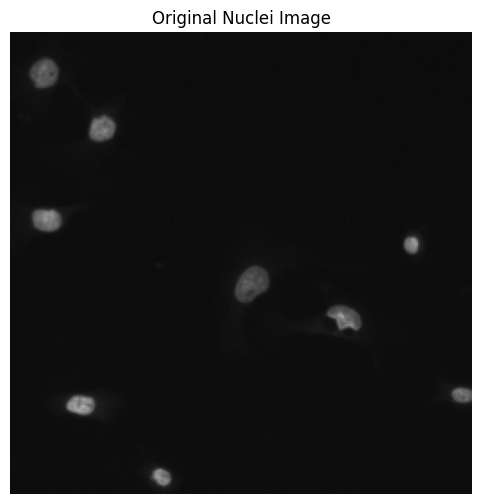

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Select one sample
sample_id = os.listdir(train_path)[0]

# Load image
img_path = os.path.join(train_path, sample_id, "images", sample_id + ".png")
img = cv2.imread(img_path)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Nuclei Image")
plt.axis("off")
plt.show()


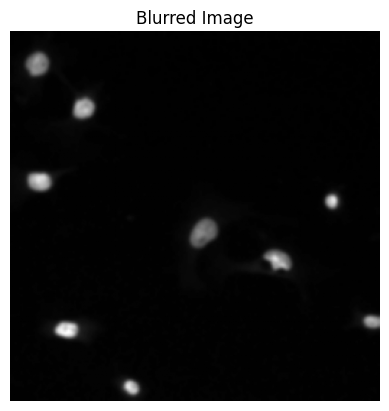

In [12]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blur = cv2.GaussianBlur(gray, (5,5), 0)

plt.imshow(blur, cmap='gray')
plt.title("Blurred Image")
plt.axis("off")
plt.show()


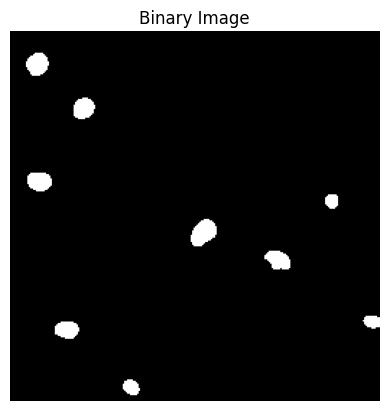

In [13]:
_, thresh = cv2.threshold(
    blur, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

plt.imshow(thresh, cmap='gray')
plt.title("Binary Image")
plt.axis("off")
plt.show()


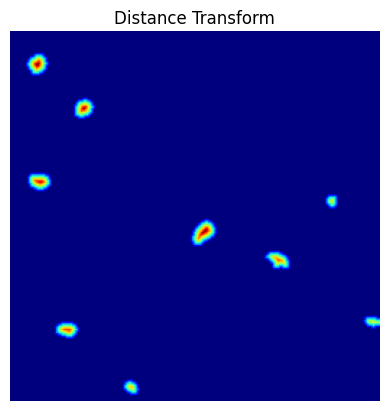

In [14]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

plt.imshow(dist, cmap='jet')
plt.title("Distance Transform")
plt.axis("off")
plt.show()


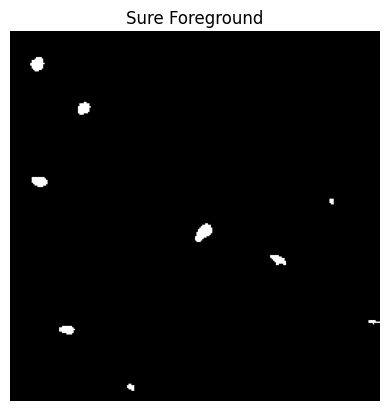

In [15]:
_, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

plt.imshow(sure_fg, cmap='gray')
plt.title("Sure Foreground")
plt.axis("off")
plt.show()


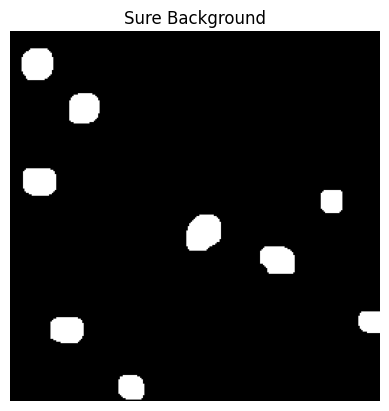

In [16]:
kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

plt.imshow(sure_bg, cmap='gray')
plt.title("Sure Background")
plt.axis("off")
plt.show()


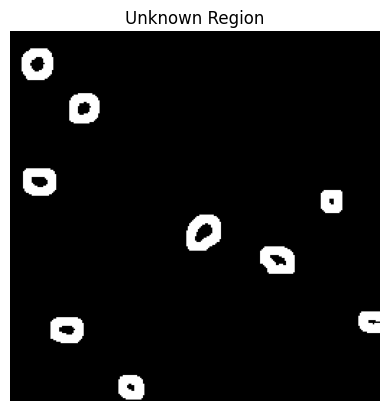

In [17]:
unknown = cv2.subtract(sure_bg, sure_fg)

plt.imshow(unknown, cmap='gray')
plt.title("Unknown Region")
plt.axis("off")
plt.show()


In [18]:
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0


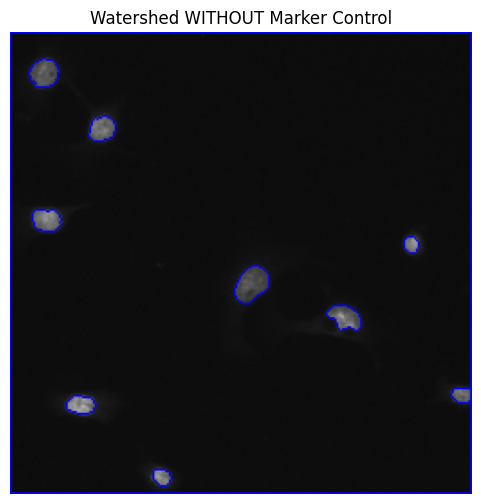

In [19]:
img_ws = img.copy()
markers = cv2.watershed(img_ws, markers)

img_ws[markers == -1] = [255,0,0]

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_ws, cv2.COLOR_BGR2RGB))
plt.title("Watershed WITHOUT Marker Control")
plt.axis("off")
plt.show()


In [20]:
# Search for an image with larger number of nuclei
for id in os.listdir(train_path):
    mask_folder = os.path.join(train_path, id, "masks")
    if len(os.listdir(mask_folder)) > 20:   # many nuclei
        sample_id = id
        break

print("Selected sample:", sample_id)


Selected sample: b560dba92fbf2af785739efced50d5866c86dc4dada9be3832138bef4c3524d2


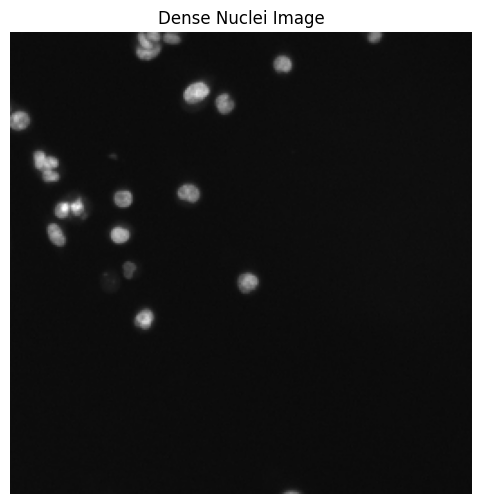

In [21]:
sample_id = "b560dba92fbf2af785739efced50d5866c86dc4dada9be3832138bef4c3524d2"

img_path = os.path.join(train_path, sample_id, "images", sample_id + ".png")
img = cv2.imread(img_path)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Dense Nuclei Image")
plt.axis("off")
plt.show()


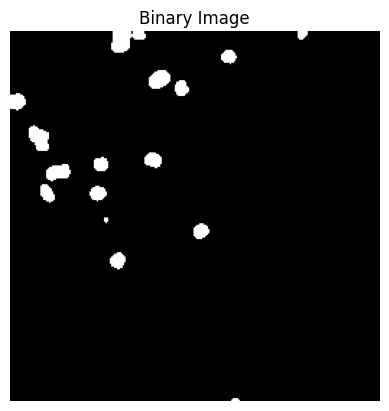

In [22]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)

_, thresh = cv2.threshold(
    blur, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

plt.imshow(thresh, cmap='gray')
plt.title("Binary Image")
plt.axis("off")
plt.show()


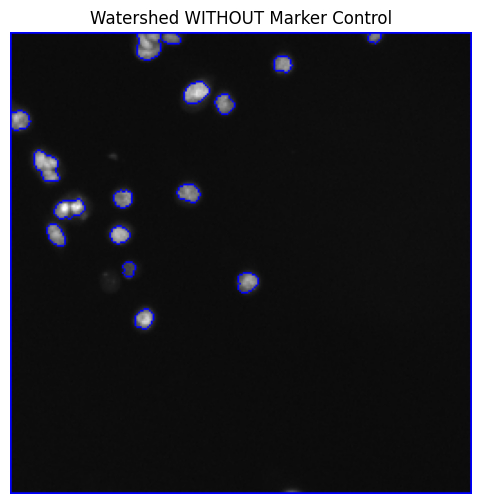

In [24]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

_, sure_fg = cv2.threshold(dist, 0.2 * dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

img_ws = img.copy()
markers = cv2.watershed(img_ws, markers)

img_ws[markers == -1] = [255,0,0]

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_ws, cv2.COLOR_BGR2RGB))
plt.title("Watershed WITHOUT Marker Control")
plt.axis("off")
plt.show()


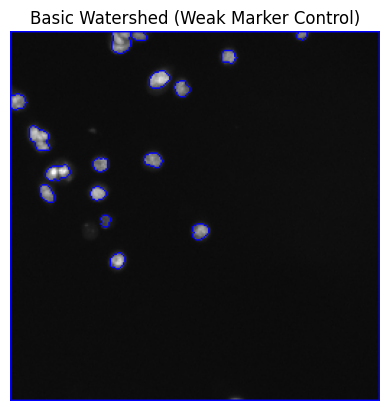

In [25]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

# Low threshold → more small seeds
_, sure_fg = cv2.threshold(dist, 0.2 * dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

kernel = np.ones((3,3), np.uint8)
sure_bg = cv2.dilate(thresh, kernel, iterations=3)

unknown = cv2.subtract(sure_bg, sure_fg)

_, markers_basic = cv2.connectedComponents(sure_fg)
markers_basic = markers_basic + 1
markers_basic[unknown == 255] = 0

img_basic = img.copy()
markers_basic = cv2.watershed(img_basic, markers_basic)

img_basic[markers_basic == -1] = [255,0,0]

plt.imshow(cv2.cvtColor(img_basic, cv2.COLOR_BGR2RGB))
plt.title("Basic Watershed (Weak Marker Control)")
plt.axis("off")
plt.show()


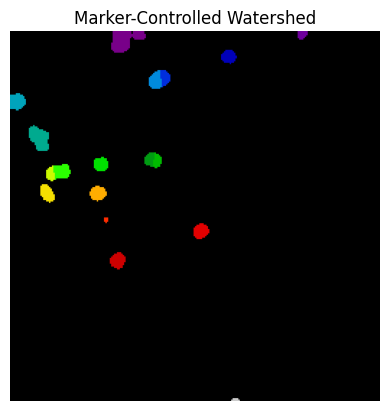

In [26]:
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed

distance = ndi.distance_transform_edt(thresh)

coords = peak_local_max(distance,
                        footprint=np.ones((25,25)),
                        labels=thresh)

mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True

markers_controlled, _ = ndi.label(mask)

labels_controlled = watershed(-distance, markers_controlled, mask=thresh)

plt.imshow(labels_controlled, cmap='nipy_spectral')
plt.title("Marker-Controlled Watershed")
plt.axis("off")
plt.show()


In [27]:
gt_count = len(os.listdir(os.path.join(train_path, sample_id, "masks")))

basic_count = len(np.unique(markers_basic)) - 2
controlled_count = len(np.unique(labels_controlled))

print("Ground Truth Nuclei:", gt_count)
print("Basic Watershed Count:", basic_count)
print("Marker-Controlled Count:", controlled_count)


Ground Truth Nuclei: 23
Basic Watershed Count: 16
Marker-Controlled Count: 19


In [29]:
print("Basic detection ratio:", 16/23)
print("Marker-controlled detection ratio:", 19/23)


Basic detection ratio: 0.6956521739130435
Marker-controlled detection ratio: 0.8260869565217391
